In [1]:
# imports
import os
from typing import Tuple
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import pylab
import scipy.stats as stats
import torch as t
from torch.nn.functional import conv2d, pad
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import IPython
import imageio
from scipy import ndimage
from tqdm import tqdm
import pandas as pd

In [2]:
# set device
device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")

In [3]:
# get_active_pixel_idx(batch: t.Tensor) -> Returns list of indices where pixels > 0
def get_active_pixel_idx(batch:t.Tensor) -> t.Tensor:
  """Get a (n,3) Tensor containing the coordinates of each active pixel in the batch.

  Args:
      batch (t.Tensor): Batch of grids (n,height,width)

  Returns:
      t.Tensor: Active pixel indices
  """  
  return batch.nonzero().T

In [200]:
def take_step(batch:t.Tensor, v_cur, p_vchg, facing_left, p_reverse, dim=-1, logging=False) -> t.Tensor:
    """Perform random step in the given dimension on each lattice in the batch.

    Args:
        batch (t.Tensor): Batch of lattices.
        p_center (t.Tensor): Probability of staying at current position.
        dim (int, optional): Dimension in which to perform the step (-2==y-dim, -1==x-dimension). Defaults to -1.
        device (_type_, optional): Torch computing device. Defaults to t.device("cpu").

    Returns:
        t.Tensor: Batch after the step was performed.
    """  
    # find active pixels
    act_pixel_idx = get_active_pixel_idx(batch)
    batch_size,height,width = batch.shape

    # determine pixels next to active pixel (uses periodic torus)
    left_px = act_pixel_idx.clone()
    right_px = act_pixel_idx.clone()
    left_px[dim] -= 1
    right_px[dim] += 1
    left_px[dim][left_px[dim] < 0] = width -1
    right_px[dim][right_px[dim] == width] = 0

    # update the direction of the cells
    logits = t.hstack([t.log(1-p_reverse).unsqueeze(-1), t.log(p_reverse).unsqueeze(-1)])
    logit_tile = logits.repeat((batch_size,1))
    outcome = t.nn.functional.gumbel_softmax(logit_tile, tau=1, hard=True)
    facing_left = facing_left * outcome[:,0] + (1 - facing_left) * outcome[:,1]
    
    # update the velocity of the cells
    logits = t.hstack([t.log(1-p_vchg), t.log(p_vchg)])
    logit_tile = logits.repeat((batch_size,1))
    v_chg = t.nn.functional.gumbel_softmax(logit_tile, tau=1, hard=True)
    v_cur = v_cur * v_chg[:,0] + (1-v_cur) * v_chg[:,1]

    batch[act_pixel_idx[0], act_pixel_idx[1], act_pixel_idx[2]] -= 1 * v_cur

    batch[left_px[0], left_px[1], left_px[2]] += facing_left * v_cur
    batch[right_px[0], right_px[1], right_px[2]] += (1-facing_left) * v_cur
    return batch, facing_left, v_cur

In [194]:
a = 1
b = 0
test1 = np.array([1,0])
print("a stays at one", test1[0] * a + b * test1[1])
test2 = np.array([0,1])
print("a goes from one to zero", test2[0] * a + b * test2[1])

a = 0
b = 1
test3 = np.array([1,0])
print("a stays at zero", test3[0] * a + b * test3[1])
test4 = np.array([0,1])
print("a goes from zero to one", test4[0] * a + b * test4[1])

a stays at one 1
a goes from one to zero 0
a stays at zero 0
a goes from zero to one 1


In [201]:
# init_batch(n:int, dim:int) -> Initialize a batch of <n> grids with size (<dim>,<dim>)
def init_batch(n:int, dim:int, device=t.device("cpu")):
  batch = t.zeros((n,dim,dim), device=device)
  batch[:,dim//2,dim//2] = 1
  facing_left_x = t.bernoulli(t.tensor(0.5).repeat(n))
  facing_left_y = t.bernoulli(t.tensor(0.5).repeat(n))
  #v_x = t.bernoulli(t.tensor(0.5).repeat(n))
  #v_y = t.bernoulli(t.tensor(0.5).repeat(n))
  v_x = t.ones((n))
  v_y = t.ones((n))
  return batch, facing_left_x, facing_left_y, v_x, v_y

In [105]:
t_b, t_x, t_y, t_vx, t_vy = init_batch(10,10)
print(t_x,t_vx)

tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.]]) tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


In [103]:
batch, dir_x, dir_y, v_x, v_y = init_batch(1,5)
p_reverse = t.tensor(0.5)
p_vchg = t.tensor(0.5)

print(batch)
for i in range(5):
    print(f"--------- MCS {i} -----------")
    batch, dir_x, v_x = take_step(batch, v_x, p_vchg, dir_x, p_reverse, dim=-1, logging=True)
    print(batch)
    batch, dir_y, v_y = take_step(batch, v_y, p_vchg, dir_y, p_reverse, dim=-2, logging=True)
    print(batch)
    

tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])
--------- MCS 0 -----------
taking a step in X direction
current direction: Left
current velocity: 1.0
direction change? Yes
updated direction: Right
change velocity? Yes
updated velocity: 0.0
tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])
taking a step in Y direction
current direction: Left
current velocity: 0.0
direction change? Yes
updated direction: Right
change velocity? Yes
updated velocity: 1.0
tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0.]]])
--------- MCS 1 -----------
taking a step in X direction
current direction: Right
current velocity: 0.0
direction change? No
updated direction: Right
change velocity? Yes


In [41]:
# create_dist_matrix(batch:t.Tensor) -> Create distance matrix with same width/height as reference batch
def create_dist_matrix(batch:t.Tensor, device=t.device("cpu")) -> t.Tensor:
    """Create distance matrix with same width/height as reference batch.

    Args:
        batch (t.Tensor): Reference batch.
        device (optional): Torch computing device. Defaults to t.device("cpu").

    Returns:
        t.Tensor: distance matrix.
    """    
    dist_matrix:np.ndarray = ndimage.distance_transform_edt(1-batch[0].cpu(), return_indices=False)
    dist_matrix = dist_matrix**2
    dist_matrix_t = t.from_numpy(dist_matrix).to(device)
    return dist_matrix_t

In [42]:
# calc_stats(batch:t.Tensor, dist_matrix:t.Tensor) -> Returns (sq_distances, avg_sq_distance, std_distance)
def calc_stats(batch:t.Tensor, dist_matrix:t.Tensor) -> Tuple[t.Tensor, t.Tensor, t.Tensor]:
  """Calculate summary statistics of the batch, I.e. Square displacements, 
  Mean Square displacement and Standard deviation of the displacements.

  Args:
      batch (t.Tensor): Batch to calculate summary statistics for.
      dist_matrix (t.Tensor): Reference distance matrix used to calculate the displacements.

  Returns:
      Tuple[t.Tensor, t.Tensor, t.Tensor]: Summary statistics.
  """  
  #print(batch.nonzero(as_tuple=True))
  #print(dist_matrix.is_cuda, batch.is_cuda)
  distances = (dist_matrix[batch.nonzero(as_tuple=True)[1:]] * batch[batch.nonzero(as_tuple=True)])
  return distances, t.mean(distances), t.std(distances)

torch.Size([100, 512, 512])


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:44<00:00,  4.49s/it]


done


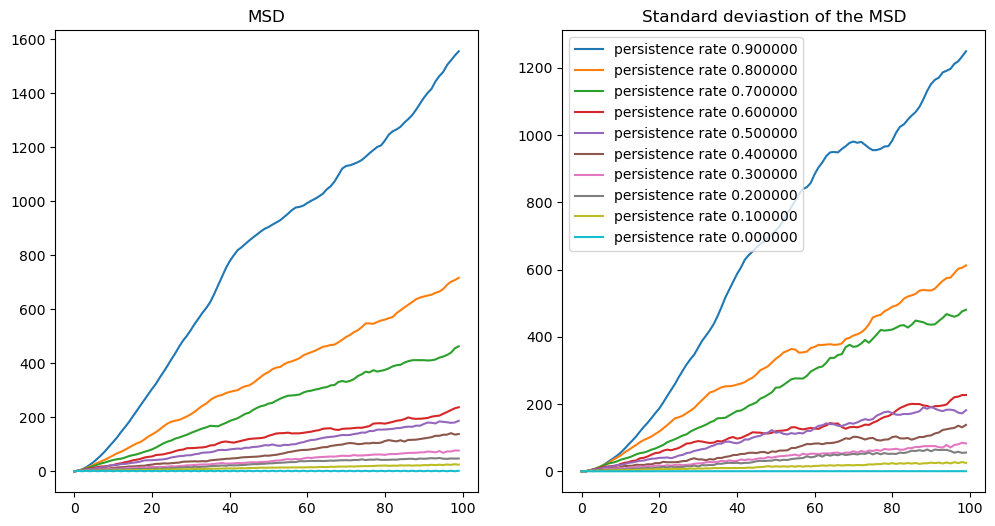

In [204]:
# plot statistics for different probabilities
p_reverse_vals = t.linspace(0.1,1,10)
p_vchg = t.tensor(0.001)
ref_grid = t.zeros((1,512,512))
ref_grid[0,256,256] = 1
dist_mtx = create_dist_matrix(ref_grid)
test_batch, dir_x, dir_y, v_x, v_y = init_batch(100,512)
print(test_batch.shape)

fig, axs = plt.subplots(1,2,figsize=(12,6))

for p_reverse in tqdm(p_reverse_vals):
  msds = []
  stds = []
  test_batch, dir_x, dir_y, v_x, v_y = init_batch(100,512)

  for i in range(100):
    distances, msd, std = calc_stats(test_batch,dist_mtx)
    msds.append(msd)
    stds.append(std)
    test_batch, dir_x, v_x = take_step(test_batch, v_x, p_vchg, dir_x, p_reverse, dim=-1)
    test_batch, dir_y, v_y = take_step(test_batch, v_y, p_vchg, dir_y, p_reverse, dim=-2)


  axs[0].plot(msds, label=f"persistence rate {(1-p_reverse):2f}")
  axs[1].plot(stds, label=f"persistence rate {(1-p_reverse):2f}")

axs[0].set_title("MSD")
axs[1].set_title("Standard deviastion of the MSD")
axs[1].legend()

print("done")

In [160]:
p_reverse = t.linspace(0.1,0.95,18)
p_vchg = t.linspace(0.1,0.95,18)
ref_grid = t.zeros((1,512,512))
ref_grid[0,256,256] = 1
dist_mtx = create_dist_matrix(ref_grid)

msds = []
stds = []
for p_rev_cur in p_reverse:
    for p_vchg_cur in tqdm(p_vchg):
        msds_cur = []
        stds_cur = []
        test_batch, dir_x, dir_y, v_x, v_y = init_batch(100,512)

        for step in range(50):
            distances, msd, std = calc_stats(test_batch,dist_mtx)
            msds_cur.append(msd)
            stds_cur.append(std)
            test_batch, dir_x, v_x = take_step(test_batch, v_x, p_vchg_cur, dir_x, p_rev_cur, dim=-1)
            test_batch, dir_y, v_y = take_step(test_batch, v_y, p_vchg_cur, dir_y, p_rev_cur, dim=-2)
        
        msds.append(msds_cur)
        stds.append(stds_cur)

  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:38<00:00,  2.14s/it]


In [117]:
85/5

17.0

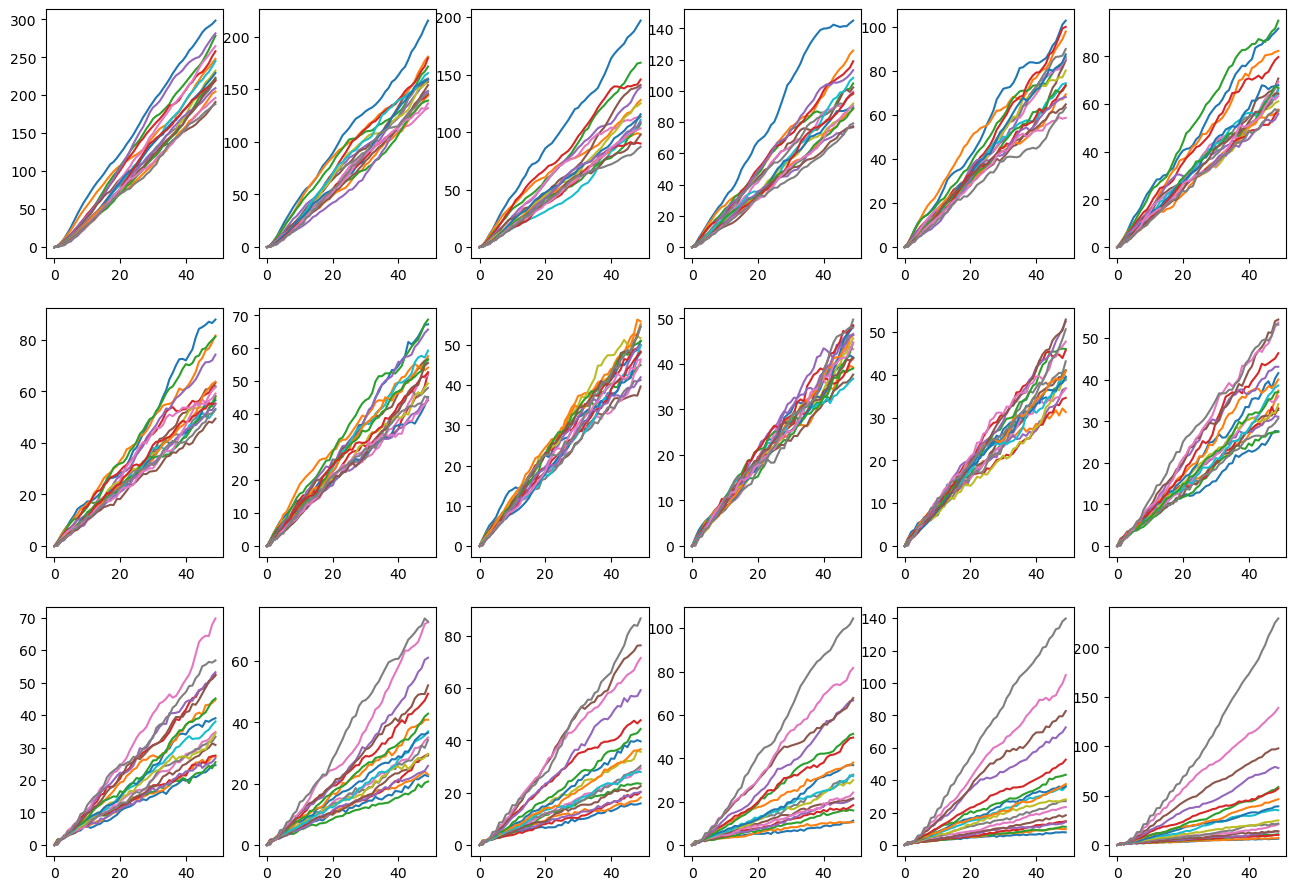

In [173]:
fig, axs = plt.subplots(3,6,figsize=(16,11))
for i in range(3):
    for j in range(6):
        for k in range(18):
            #print(i,j,(i*6)+j,(i*6+j)*18+k)
            axs[i,j].plot(msds[(i*6+j)*18+k])